 Подключим необходимые библиотеки

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import io

import warnings
warnings.filterwarnings("ignore")

Загрузим данные и посмотрим на них с помощью sql запроса

In [ ]:
prod = pd.read_csv('product.csv')

In [ ]:
con = sqlite3.connect(':memory:')

def select(sql, data):
    for data_ in data: 
        data_.to_sql(prod, con, index = False, if_exists= 'replace')
    return pd.read_sql(sql, con)

In [ ]:
sql = '''
SELECT *
FROM prod
LIMIT 5
'''

select(sql, [prod])

,order_id,user_id,page_id,product,site_version,time,title,target
0,cfcd208495d565ef66e7dff9f98764da,c81e728d9d4c2f636f067f89cc14862c,6f4922f45568161a8cdf4ad2299f6d23,sneakers,desktop,2019-01-11 09:24:43,banner_click,0
1,c4ca4238a0b923820dcc509a6f75849b,eccbc87e4b5ce2fe28308fd9f2a7baf3,4e732ced3463d06de0ca9a15b6153677,sneakers,desktop,2019-01-09 09:38:51,banner_show,0
2,c81e728d9d4c2f636f067f89cc14862c,eccbc87e4b5ce2fe28308fd9f2a7baf3,5c45a86277b8bf17bff6011be5cfb1b9,sports_nutrition,desktop,2019-01-09 09:12:45,banner_show,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,eccbc87e4b5ce2fe28308fd9f2a7baf3,fb339ad311d50a229e497085aad219c7,company,desktop,2019-01-03 08:58:18,banner_show,0
4,a87ff679a2f3e71d9181a67b7542122c,eccbc87e4b5ce2fe28308fd9f2a7baf3,fb339ad311d50a229e497085aad219c7,company,desktop,2019-01-03 08:59:15,banner_click,0


## В каком месяце было показано больше всего рекламы пользователям?

In [ ]:
sql = '''
SELECT strftime('%m', time) as Month, count(*)
FROM prod
WHERE title='banner_show'
GROUP BY Month
'''

select(sql, [prod])

,Month,count(*)
0,01,1281223
1,02,1103272
2,03,1436165
3,04,1706503
4,05,1866151


В мае было больше всего показов рекламы пользователям. Также можем видеть, что почти в каждом месяце это число возрастает

## Какая средняя конверсия в клик?

In [ ]:
sql = '''
SELECT product,
sum(case when title='banner_click' then 1 else 0 end) as clicks,
sum(case when title='banner_show' then 1 else 0 end) as shows,
1.0 * sum(case when title='banner_click' then 1 else 0 end) / sum(case when title='banner_show' then 1 else 0 end) as converse
FROM prod
'''

select(sql, [prod])

,product,clicks,shows,converse
0,sneakers,829184,7393314,0.112153


Средняя конверсия по всем баннерам составляет 0.11. Значит, всего 11% пользователей кликали на баннер при просмотре

## Отличается ли конверсия в клик у различных платформ desktop/mobile?

In [ ]:
sql = '''
SELECT site_version,
sum(case when title='banner_click' then 1 else 0 end) as clicks,
sum(case when title='banner_show' then 1 else 0 end) as shows,
1.0 * sum(case when title='banner_click' then 1 else 0 end) / sum(case when title='banner_show' then 1 else 0 end) as converse
FROM prod
GROUP BY site_version
'''

select(sql, [prod])

,site_version,clicks,shows,converse
0,desktop,115065,2134639,0.053904
1,mobile,714119,5258675,0.135798


Здесь видим, что конверсия в клик на десктопе значительно ниже, чем на мобильных устройствах. Однако и количество показов на десктопе тоже меньше. Возможно, сайт разработан больше для пользователей мобильных устройств, на десктопе интерфейс может показываться криво, что в последствии дает малую конверсию

## Рекламу какого продукта клиенты охотнее всего нажимают (Наибольшая конверсия)? Зависит ли это от платформы и менялось ли это во времени?

In [ ]:
sql = '''
SELECT product,
sum(case when title='banner_click' then 1 else 0 end) as clicks,
sum(case when title='banner_show' then 1 else 0 end) as shows,
1.0 * sum(case when title='banner_click' then 1 else 0 end) / sum(case when title='banner_show' then 1 else 0 end) as converse
FROM prod
GROUP BY product
'''

click_converse_products = select(sql, [prod])

In [ ]:
click_converse_products

,product,clicks,shows,converse
0,accessories,136254,1440954,0.094558
1,clothes,220595,1453128,0.151807
2,company,144821,1580235,0.091645
3,sneakers,182596,1453027,0.125666
4,sports_nutrition,144918,1465970,0.098855


Отсюда видим, что чаще всего нажимают на банер с одеждой

Теперь посмотрим, было ли это так постоянно, или же это значение лишь среднее, которое по случайности оказалось больше остальных

In [ ]:
sql = '''
SELECT product, date(time) as date,
sum(case when title='banner_click' then 1 else 0 end) as clicks,
sum(case when title='banner_show' then 1 else 0 end) as shows,
1.0 * sum(case when title='banner_click' then 1 else 0 end) / sum(case when title='banner_show' then 1 else 0 end) as converse
FROM prod
GROUP BY date, product
'''

click_converse_every_day_by_products = select(sql, [prod])

In [ ]:
click_converse_every_day_by_products

,product,date,clicks,shows,converse
0,accessories,2019-01-01,560,5865,0.095482
1,clothes,2019-01-01,875,5732,0.152652
2,company,2019-01-01,555,5749,0.096539
3,sneakers,2019-01-01,718,5871,0.122296
4,sports_nutrition,2019-01-01,652,5776,0.112881
...,...,...,...,...,...
750,accessories,2019-05-31,682,6674,0.102188
751,clothes,2019-05-31,1045,7017,0.148924
752,company,2019-05-31,672,7075,0.094982
753,sneakers,2019-05-31,868,6894,0.125907


<AxesSubplot:xlabel='date', ylabel='converse'>

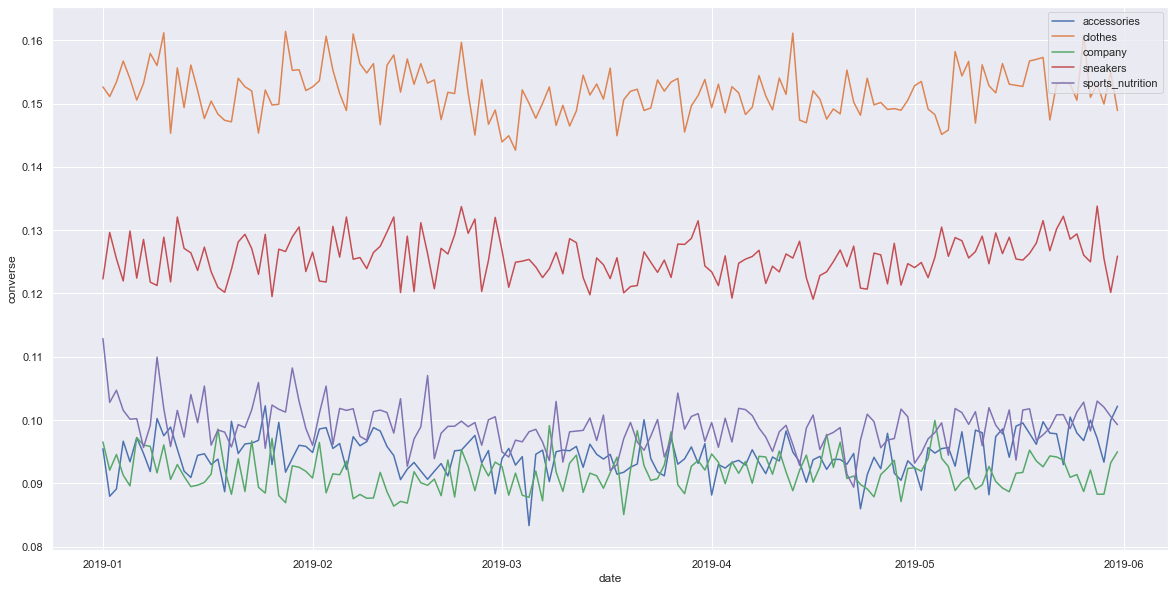

In [ ]:
click_converse.date = pd.to_datetime(click_converse.date)

sns.set(rc={'figure.figsize':(20, 10)})
pic = sns.lineplot(data=click_converse[click_converse['product']=='accessories'][['date','converse','product']], x='date', y='converse', label="accessories")
sns.lineplot(data=click_converse[click_converse['product']=='clothes'][['date','converse','product']], x='date', y='converse', label="clothes")
sns.lineplot(data=click_converse[click_converse['product']=='company'][['date','converse','product']], x='date', y='converse', label="company")
sns.lineplot(data=click_converse[click_converse['product']=='sneakers'][['date','converse','product']], x='date', y='converse', label="sneakers")
sns.lineplot(data=click_converse[click_converse['product']=='sports_nutrition'][['date','converse','product']], x='date', y='converse', label="sports_nutrition")

#sns.legend()

Теперь видно, что реклама одежды всегда приносила большие конверсии, чем любой другой баннер

Проверим, как на конверсии влияет платформа

In [ ]:
sql = '''
SELECT product, site_version,
sum(case when title='banner_click' then 1 else 0 end) as clicks,
sum(case when title='banner_show' then 1 else 0 end) as shows,
1.0 * sum(case when title='banner_click' then 1 else 0 end) / sum(case when title='banner_show' then 1 else 0 end) as converse
FROM prod
GROUP BY site_version, product
'''

click_converse = select(sql, [prod])

In [ ]:
click_converse

,product,site_version,clicks,shows,converse
0,accessories,desktop,18531,410003,0.045197
1,clothes,desktop,32781,418070,0.078410
2,company,desktop,28464,477374,0.059626
3,sneakers,desktop,21419,411597,0.052039
4,sports_nutrition,desktop,13870,417595,0.033214
5,accessories,mobile,117723,1030951,0.114189
6,clothes,mobile,187814,1035058,0.181453
7,company,mobile,116357,1102861,0.105505
8,sneakers,mobile,161177,1041430,0.154765
9,sports_nutrition,mobile,131048,1048375,0.125001


Здесь видим, что как и в общей статистике, реклама на десктопе приносит значительно меньше, чем на мобильном. Причем это не зависит от баннера. Это снова дает повод подумать, что с десктоп версией сайта что-то не так

## Есть ли корреляция между количеством показов баннера клиенту и конверсией в клик?

In [ ]:
click_converse_every_day_by_products

,product,date,clicks,shows,converse
0,accessories,2019-01-01,560,5865,0.095482
1,clothes,2019-01-01,875,5732,0.152652
2,company,2019-01-01,555,5749,0.096539
3,sneakers,2019-01-01,718,5871,0.122296
4,sports_nutrition,2019-01-01,652,5776,0.112881
...,...,...,...,...,...
750,accessories,2019-05-31,682,6674,0.102188
751,clothes,2019-05-31,1045,7017,0.148924
752,company,2019-05-31,672,7075,0.094982
753,sneakers,2019-05-31,868,6894,0.125907


In [ ]:
np.corrcoef(click_converse_every_day_by_products.shows, click_converse_every_day_by_products.converse)

array([[ 1.        , -0.07996398],
       [-0.07996398,  1.        ]])

Видим, что корреляция между количеством показов баннера клиенту и конверсией в клик отсутствует. Значит, конверсия скорее зависит от определенного баннера, чем от количества его показов

## Как зависит конверсия в клик от количества покупок, которые сделал клиент?

In [ ]:
sql = '''
SELECT user_id,
sum(case when title='order' then 1 else 0 end) as purchases,
sum(case when title='banner_click' then 1 else 0 end) as clicks,
sum(case when title='banner_show' then 1 else 0 end) as shows,
1.0 * sum(case when title='banner_click' then 1 else 0 end) / sum(case when title='banner_show' then 1 else 0 end) as converse
FROM prod
GROUP BY user_id
'''

click_converse_users = select(sql, [prod])

In [ ]:
click_converse_users

,user_id,purchases,clicks,shows,converse
0,0000023f507999464aa2b78875b7e5d6,0,0,1,0.000000
1,000009891526c0ade7180f8423792063,0,0,1,0.000000
2,00000ce845c00cbf0686c992fc369df4,0,0,1,0.000000
3,00000f7264c27ba6fea0c837ed6aa0aa,0,0,1,0.000000
4,0000104cd168386a335ba6bf6e32219d,1,1,2,0.500000
...,...,...,...,...,...
4254614,ffffe3323c6b5c056c19b2722c9aacbc,0,1,1,1.000000
4254615,fffff8d603b897bb8655858430adfe40,0,2,6,0.333333
4254616,fffff9055756ed29a5aa13ee8e222ac8,0,1,1,1.000000
4254617,fffffa6bed6b7780465149fab05cf406,0,0,3,0.000000


In [ ]:
np.corrcoef(click_converse_users[click_converse_users.purchases>0].converse, click_converse_users[click_converse_users.purchases>0].purchases)

array([[ 1.0000000e+00, -6.4625786e-04],
       [-6.4625786e-04,  1.0000000e+00]])

Какой либо зависимости между конверсией в клик и количеством покупок, которые сделал клиент не обнаружено.

In [ ]:
print('Количество пользователей с ненулевой конверсией, совершавшие покупки: {}'.format(len(click_converse_users[click_converse_users.purchases>0][click_converse_users.converse>0])))
print('Количество пользователей с нулевой конверсией, совершавшие покупки: {}'.format(len(click_converse_users[click_converse_users.purchases>0][click_converse_users.converse==0])))
    
print('Количество пользователей с ненулевой конверсией, не совершавшие покупки: {}'.format(len(click_converse_users[click_converse_users.purchases==0][click_converse_users.converse>0])))
print('Количество пользователей с нулевой конверсией, не совершавшие покупки: {}'.format(len(click_converse_users[click_converse_users.purchases==0][click_converse_users.converse==0])))

Количество пользователей с ненулевой конверсией, совершавшие покупки: 112069
Количество пользователей с нулевой конверсией, совершавшие покупки: 125797
Количество пользователей с ненулевой конверсией, не совершавшие покупки: 630388
Количество пользователей с нулевой конверсией, не совершавшие покупки: 3386364


Видим, что количество пользователей, совершивших покупку почти одинаково с конверсией и без. Однако есть большое количество пользователей, не совершивших покупку и нажавших на баннер. Реклама привлекает пользователей, но многие из них не доходят до покупки

## Можно ли на данном датасорсе посчитать конверсию в покупку?

Можно, таким же способом, как в предыдущем пункте, сгруппировав данные по пользователям

In [ ]:
sql = '''
SELECT user_id,
sum(case when title='order' then 1 else 0 end) as purchases,
sum(case when title='banner_click' then 1 else 0 end) as clicks,
1.0 * sum(case when title='order' then 1 else 0 end) / sum(case when title='banner_click' then 1 else 0 end) as converse
FROM prod
GROUP BY user_id
'''

click_converse_purchase = select(sql, [prod])

In [ ]:
click_converse_purchase

,user_id,purchases,clicks,converse
0,0000023f507999464aa2b78875b7e5d6,0,0,NaN
1,000009891526c0ade7180f8423792063,0,0,NaN
2,00000ce845c00cbf0686c992fc369df4,0,0,NaN
3,00000f7264c27ba6fea0c837ed6aa0aa,0,0,NaN
4,0000104cd168386a335ba6bf6e32219d,1,1,1.0
...,...,...,...,...
4254614,ffffe3323c6b5c056c19b2722c9aacbc,0,1,0.0
4254615,fffff8d603b897bb8655858430adfe40,0,2,0.0
4254616,fffff9055756ed29a5aa13ee8e222ac8,0,1,0.0
4254617,fffffa6bed6b7780465149fab05cf406,0,0,NaN


In [ ]:
click_converse_purchase.converse.mean()

0.14611906859185164

Посчитали, что конверсия в покупку = 0.15. Это значит, что в среднем 15% пользователей делают покупку после того, как нажали на баннер на главной странице.

## Выводы

После поверхностного анализа данных выяснилось, что десктоп версия дает значительно меньшую конверсию, чем мобильная версия. Значит, стоит проверить работу сайта на десктопе \
Также выяснилось, что наибольшую конверсию дает реклама одежды. Скорее всего, для пользователей данная категория наиболее актуальна. \
Клики по баннерам не влияют на количество покупок. Возможно, не все пользователи видят на них актуальную для них на данный момент категорию.